In [ ]:
# https://github.com/marybun/machine_learning

In [1]:
import numpy as np
from processdata import load_data, TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from processdata import load_full_SST

load_X = load_data('SST')

num_epochs = 200

In [2]:
# Function to train and valid the model for a specific lags and num_sensors
# Return mean square error as comparing to the ground truth values.
def SHREDperformance(lags=52, num_sensors=3, alpha=0, isPlot=False, num_epochs=50):
    n = load_X.shape[0]
    m = load_X.shape[1]
    # Randomly select num_sensors sensor locations and set the trajectory length (lags) to lags, 
    # corresponding to one year of measurements.
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    # select indices to divide the data into training, validation, and test sets.
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    # sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets.

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    ## Add Gaussian noise with zero mean if alpha is not zero
    if alpha != 0.0:
        avg_x = torch.mean(abs(train_data_in))
        std_dev = alpha * train_data_in
        noise = torch.randn_like(train_data_in) * std_dev 
        train_data_in = train_data_in + noise
    
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # We train the model using the training and validation datasets.
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=num_epochs, lr=1e-3, verbose=True, patience=5)

    # Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse=np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print("mean square error:", mse)

    # Plot if asked for
    if(isPlot):
        # SST data with world map indices for plotting
        full_SST, sst_locs = load_full_SST()
        full_test_truth = full_SST[test_indices, :]

        # replacing SST data with our reconstruction
        full_test_recon = full_test_truth.copy()
        full_test_recon[:,sst_locs] = test_recons

        # reshaping to 2d frames
        for x in [full_test_truth, full_test_recon]:
            x.resize(len(x),180,360)
        plotdata = [full_test_truth, full_test_recon]
        labels = ['truth','recon']
        fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
        for axis,p,label in zip(ax, plotdata, labels):
            axis.imshow(p[0])
            axis.set_aspect('equal')
            axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)
    return mse

epoch: 200 valid_error: tensor(0.1779): 100%|██████████| 200/200 [11:01<00:00,  3.31s/it]


mean square error: 0.031557165


0.031557165

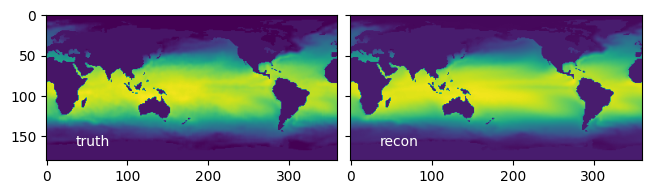

In [3]:
# Train the model and plot the results
lags = 52
num_sensors = 3
alpha = 0.0 # no noise added
SHREDperformance(lags, num_sensors, alpha, isPlot=True, num_epochs=num_epochs)

epoch: 200 valid_error: tensor(0.2069): 100%|██████████| 200/200 [10:13<00:00,  3.07s/it]


mean square error: 0.035944473


epoch: 200 valid_error: tensor(0.2360): 100%|██████████| 200/200 [10:10<00:00,  3.05s/it]


mean square error: 0.04794024


epoch: 200 valid_error: tensor(0.1921): 100%|██████████| 200/200 [10:15<00:00,  3.08s/it]


mean square error: 0.03426202


epoch: 200 valid_error: tensor(0.1911): 100%|██████████| 200/200 [10:33<00:00,  3.17s/it]


mean square error: 0.034400333


epoch: 200 valid_error: tensor(0.1835): 100%|██████████| 200/200 [10:21<00:00,  3.11s/it]


mean square error: 0.032346416


epoch: 200 valid_error: tensor(0.1654): 100%|██████████| 200/200 [10:10<00:00,  3.05s/it]


mean square error: 0.030091489


epoch: 200 valid_error: tensor(0.1693): 100%|██████████| 200/200 [10:09<00:00,  3.05s/it]


mean square error: 0.030907627


epoch: 200 valid_error: tensor(0.1878): 100%|██████████| 200/200 [10:41<00:00,  3.21s/it]


mean square error: 0.03255699


epoch: 200 valid_error: tensor(0.1666): 100%|██████████| 200/200 [10:59<00:00,  3.30s/it]


mean square error: 0.028949693


epoch: 200 valid_error: tensor(0.1716): 100%|██████████| 200/200 [10:47<00:00,  3.24s/it]


mean square error: 0.030537266


epoch: 200 valid_error: tensor(0.1484): 100%|██████████| 200/200 [10:51<00:00,  3.26s/it]


mean square error: 0.026909867


epoch: 200 valid_error: tensor(0.1768): 100%|██████████| 200/200 [11:02<00:00,  3.31s/it]


mean square error: 0.031034762


epoch: 200 valid_error: tensor(0.1745): 100%|██████████| 200/200 [11:11<00:00,  3.36s/it]


mean square error: 0.030554738


Text(0.5, 1.0, 'Performance of SHRED as a function of the time lag variable')

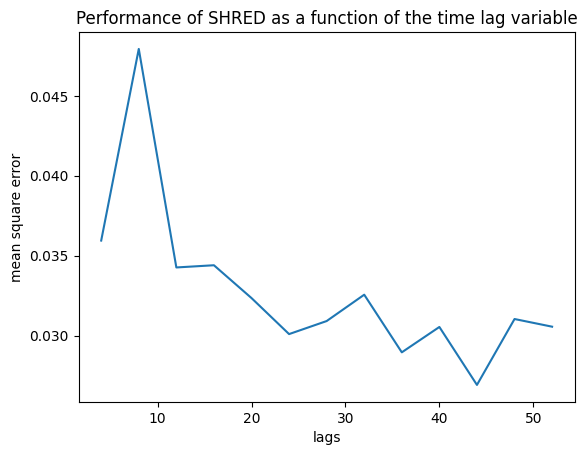

In [4]:
# Do an analysis of the performance as a function of the time lag variable
num_sensors = 3
alpha = 0.0 # no noise added
# Loop through a range of lags
lags = range(4,53,4) 
mses_by_lags = np.zeros(len(lags))
for i in range(len(lags)):
    mses_by_lags[i] = SHREDperformance(lags[i], num_sensors, alpha, isPlot=False, num_epochs=num_epochs)
plt.plot(lags, mses_by_lags)
plt.ylabel("mean square error")
plt.xlabel("lags")
plt.title("Performance of SHRED as a function of the time lag variable")

epoch: 200 valid_error: tensor(0.1445): 100%|██████████| 200/200 [10:42<00:00,  3.21s/it]


mean square error: 0.026796553


epoch: 200 valid_error: tensor(0.1424): 100%|██████████| 200/200 [10:36<00:00,  3.18s/it]


mean square error: 0.02577156


epoch: 200 valid_error: tensor(0.1530): 100%|██████████| 200/200 [10:32<00:00,  3.16s/it]


mean square error: 0.0275188


epoch: 200 valid_error: tensor(0.1611): 100%|██████████| 200/200 [10:53<00:00,  3.27s/it]


mean square error: 0.02924804


epoch: 200 valid_error: tensor(0.1558): 100%|██████████| 200/200 [10:51<00:00,  3.26s/it]


mean square error: 0.028754972


epoch: 200 valid_error: tensor(0.1582): 100%|██████████| 200/200 [11:04<00:00,  3.32s/it]


mean square error: 0.028577292


epoch: 200 valid_error: tensor(0.1517): 100%|██████████| 200/200 [10:59<00:00,  3.30s/it]


mean square error: 0.027980579


epoch: 200 valid_error: tensor(0.1603): 100%|██████████| 200/200 [10:41<00:00,  3.21s/it]


mean square error: 0.029354153


epoch: 200 valid_error: tensor(0.1534): 100%|██████████| 200/200 [10:55<00:00,  3.28s/it]


mean square error: 0.028147502


epoch: 200 valid_error: tensor(0.1933): 100%|██████████| 200/200 [11:03<00:00,  3.32s/it]


mean square error: 0.03401036


epoch: 200 valid_error: tensor(0.1655): 100%|██████████| 200/200 [10:54<00:00,  3.27s/it]

mean square error: 0.02967298


Text(0.5, 1.0, 'Performance of SHRED as a function of noise (alpha)')

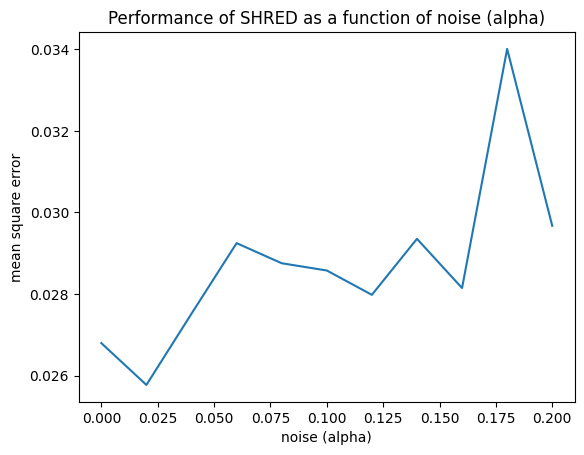

In [5]:
# Do an analysis of the performance as a function of noise (add Gaussian noise to data)
# Noise has mean zero and standard deviation equal to alpha times the mean absolute value of the field
lags = 52
num_sensors = 3
# Loop through a range of noises
alphas = np.arange(0.0,0.21,0.02) 
mses_by_alpha = np.zeros(len(alphas))
for i in range(len(alphas)):
    mses_by_alpha[i] = SHREDperformance(lags, num_sensors, alpha=alphas[i], isPlot=False, num_epochs=num_epochs)
plt.plot(alphas, mses_by_alpha)
plt.ylabel("mean square error")
plt.xlabel("noise (alpha)")
plt.title("Performance of SHRED as a function of noise (alpha)")

epoch: 200 valid_error: tensor(0.1768): 100%|██████████| 200/200 [11:03<00:00,  3.32s/it]


mean square error: 0.031140562


epoch: 200 valid_error: tensor(0.1544): 100%|██████████| 200/200 [11:15<00:00,  3.38s/it]


mean square error: 0.028618434


epoch: 200 valid_error: tensor(0.1370): 100%|██████████| 200/200 [2:27:00<00:00, 44.10s/it]    


mean square error: 0.024869144


epoch: 200 valid_error: tensor(0.1350): 100%|██████████| 200/200 [11:01<00:00,  3.31s/it]


mean square error: 0.024249254


epoch: 200 valid_error: tensor(0.1296): 100%|██████████| 200/200 [10:42<00:00,  3.21s/it]


mean square error: 0.02385341


epoch: 200 valid_error: tensor(0.1349): 100%|██████████| 200/200 [10:36<00:00,  3.18s/it]


mean square error: 0.024733748


epoch: 200 valid_error: tensor(0.1364): 100%|██████████| 200/200 [10:43<00:00,  3.22s/it]


mean square error: 0.025637288


epoch: 200 valid_error: tensor(0.1331): 100%|██████████| 200/200 [10:28<00:00,  3.14s/it]


mean square error: 0.02403265


epoch: 200 valid_error: tensor(0.1268): 100%|██████████| 200/200 [10:37<00:00,  3.19s/it]


mean square error: 0.023122443


epoch: 200 valid_error: tensor(0.1262): 100%|██████████| 200/200 [10:56<00:00,  3.28s/it]


mean square error: 0.02321137


epoch: 200 valid_error: tensor(0.1299): 100%|██████████| 200/200 [10:58<00:00,  3.29s/it]


mean square error: 0.023466967


epoch: 200 valid_error: tensor(0.1278): 100%|██████████| 200/200 [10:45<00:00,  3.23s/it]


mean square error: 0.023402056


Text(0.5, 1.0, 'Performance of SHRED as a function of the number of sensors')

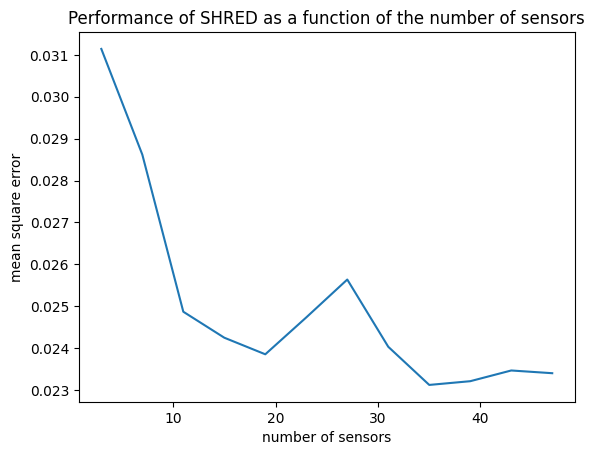

In [6]:
# Do an analysis of the performance as a function of the number of sensors
lags = 52
alpha = 0.0 # no noise added
# Loop through a range of number of sensors
num_sensors = range(3,51,4) 
mses_by_sensors = np.zeros(len(num_sensors))
for i in range(len(num_sensors)):
    mses_by_sensors[i] = SHREDperformance(lags, num_sensors[i], alpha, isPlot=False, num_epochs=num_epochs)
plt.plot(num_sensors, mses_by_sensors)
plt.ylabel("mean square error")
plt.xlabel("number of sensors")
plt.title("Performance of SHRED as a function of the number of sensors")